In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split


from keras.layers import Input,InputLayer, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout
from keras.models import Sequential,Model
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint,LearningRateScheduler
from keras_preprocessing.image import ImageDataGenerator
import keras
from keras import backend as K
import math


%matplotlib inline

In [2]:
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")

In [3]:
train.head(5)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
X_train=train.drop(labels = ["label"],axis = 1) 
Y_train=train['label']

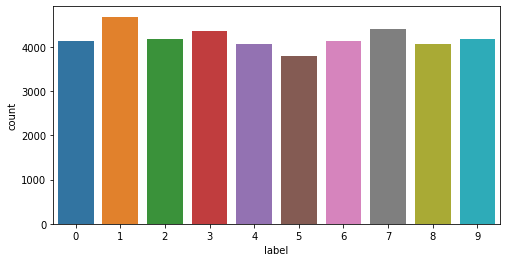

In [7]:
plt.figure(figsize=(8,4))
sns.countplot(x='label', data=train);

In [9]:
X_train=X_train.astype('float32')/255
test=test.astype('float32')/255

In [10]:
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [13]:
Y_train = to_categorical(Y_train, num_classes = 10)

In [14]:
print(Y_train[:5])

[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [15]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size = 0.1, random_state=42)

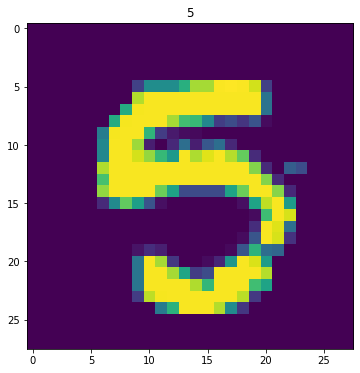

In [16]:
plt.figure(figsize=(6,6))
plt.imshow(X_train[1][:,:,0])
plt.title(Y_train[1].argmax());

In [19]:
inputShape=(28,28,1)
input = Input(inputShape)

x = Conv2D(64,(3,3),strides = (1,1),name='layer_conv1',padding='same')(input)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2,2),name='maxPool1')(x)


x = Conv2D(64,(3,3),strides = (1,1),name='layer_conv2',padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2,2),name='maxPool2')(x)

x = Conv2D(32,(3,3),strides = (1,1),name='conv3',padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2,2),name='maxPool3')(x)


x = Flatten()(x)
x = Dense(64,activation = 'relu',name='fc0')(x)
x = Dropout(0.25)(x)
x = Dense(32,activation = 'relu',name='fc1')(x)
x = Dropout(0.25)(x)
x = Dense(10,activation = 'softmax',name='fc2')(x)

model = Model(inputs = input,outputs = x,name='Predict');

In [22]:
datagen_train = ImageDataGenerator(
    width_shift_range=0.2,  # randomly shift images horizontally 
    height_shift_range=0.2,# randomly shift images vertically 

    horizontal_flip=True) # randomly flip images horizontally

# fit augmented image generator on data
datagen_train.fit(X_train)

In [25]:
# define SGD optimizer
momentum = 0.5
sgd = SGD(lr=0.01, momentum=momentum, decay=0.0, nesterov=False) 

# compile the model
model.compile(loss='categorical_crossentropy',optimizer=sgd, metrics=['accuracy']);

In [37]:
def step_decay(epoch, lr):    
    initial_lrate=lr
    drop=0.6
    epochs_drop = 3.0
    lrate= initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]

In [38]:
history=model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid),
                          epochs=5,callbacks=callbacks_list,verbose=1)

Train on 37800 samples, validate on 4200 samples
Epoch 1/5
37800/37800 [==============================] - 212s 6ms/step - loss: 0.0734 - acc: 0.9789 - val_loss: 0.0472 - val_acc: 0.9867
Epoch 2/5
37800/37800 [==============================] - 196s 5ms/step - loss: 0.0746 - acc: 0.9795 - val_loss: 0.0471 - val_acc: 0.9869
Epoch 3/5
37800/37800 [==============================] - 194s 5ms/step - loss: 0.0722 - acc: 0.9801 - val_loss: 0.0473 - val_acc: 0.9867
Epoch 4/5
37800/37800 [==============================] - 220s 6ms/step - loss: 0.0732 - acc: 0.9798 - val_loss: 0.0473 - val_acc: 0.9869
Epoch 5/5
37800/37800 [==============================] - 214s 6ms/step - loss: 0.0742 - acc: 0.9791 - val_loss: 0.0472 - val_acc: 0.9867


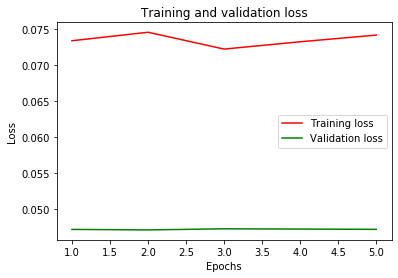

In [39]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, color='green', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

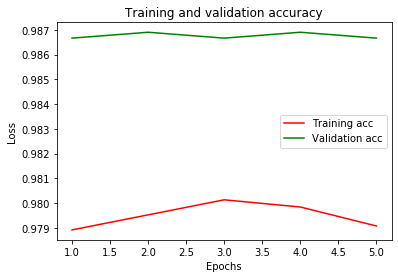

In [40]:
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, color='red', label='Training acc')
plt.plot(epochs, val_acc, color='green', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [42]:
print("on valid data")
pred1=model.evaluate(X_valid,Y_valid)
print("accuaracy", str(pred1[1]*100))
print("Total loss",str(pred1[0]*100))

on valid data
4200/4200 [==============================] - 6s 1ms/step
accuaracy 98.66666666666667
Total loss 4.722799560864501


In [49]:
layer_outputs = [layer.output for layer in model.layers if not layer.name.startswith('input')]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(X_train[10].reshape(1,28,28,1))
# layer_outputs = [layer.output for layer in w_extraction.layers[:102] if not layer.name.startswith('input')]

def display_activation(activations, col_size, row_size, act_index): 
    activation = activations[act_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*1.5))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='gray')
            activation_index += 1

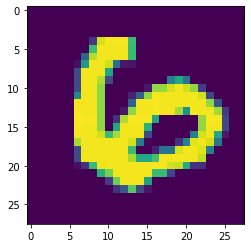

In [50]:
plt.imshow(X_train[10][:,:,0]);

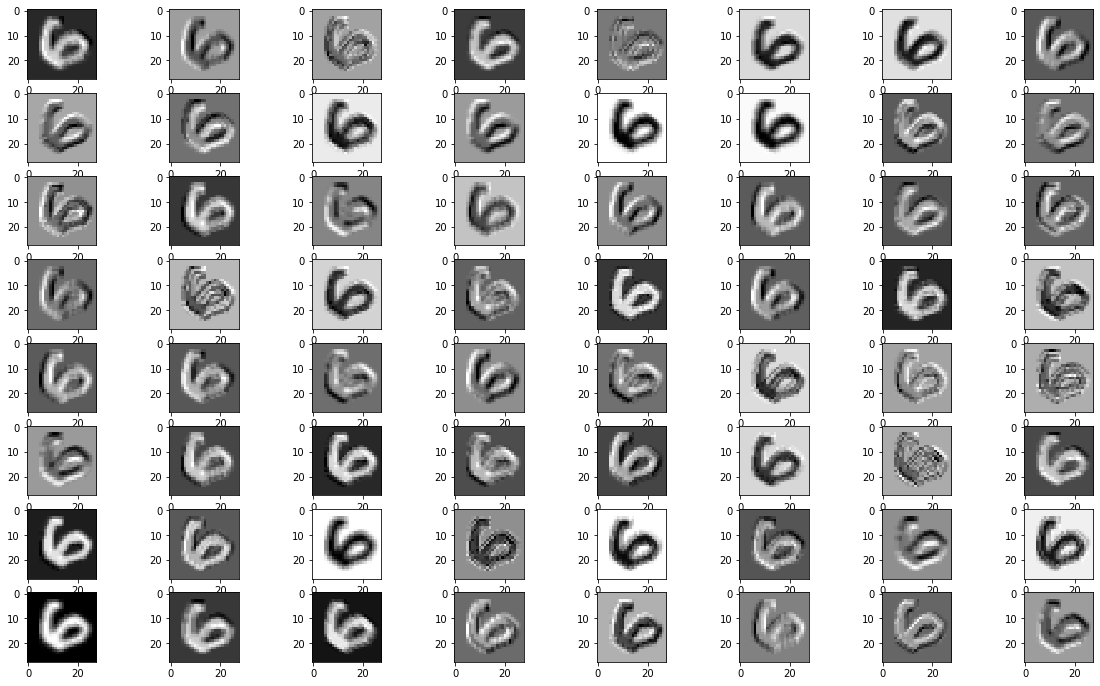

In [51]:
display_activation(activations, 8, 8, 1)

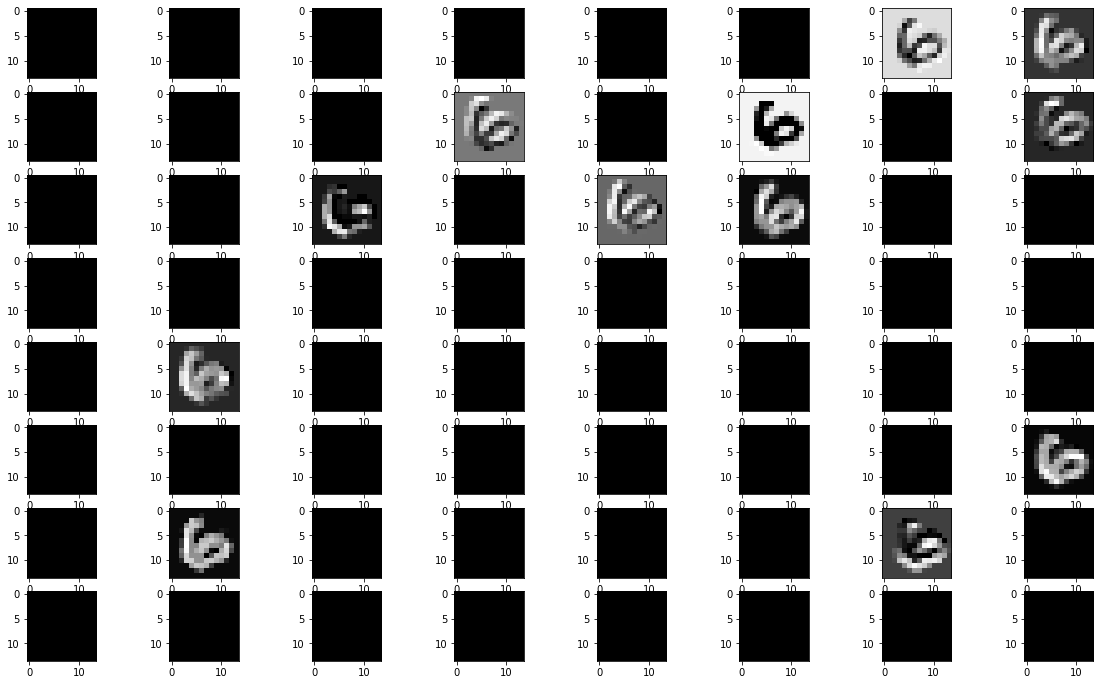

In [52]:
display_activation(activations, 8, 8, 3)

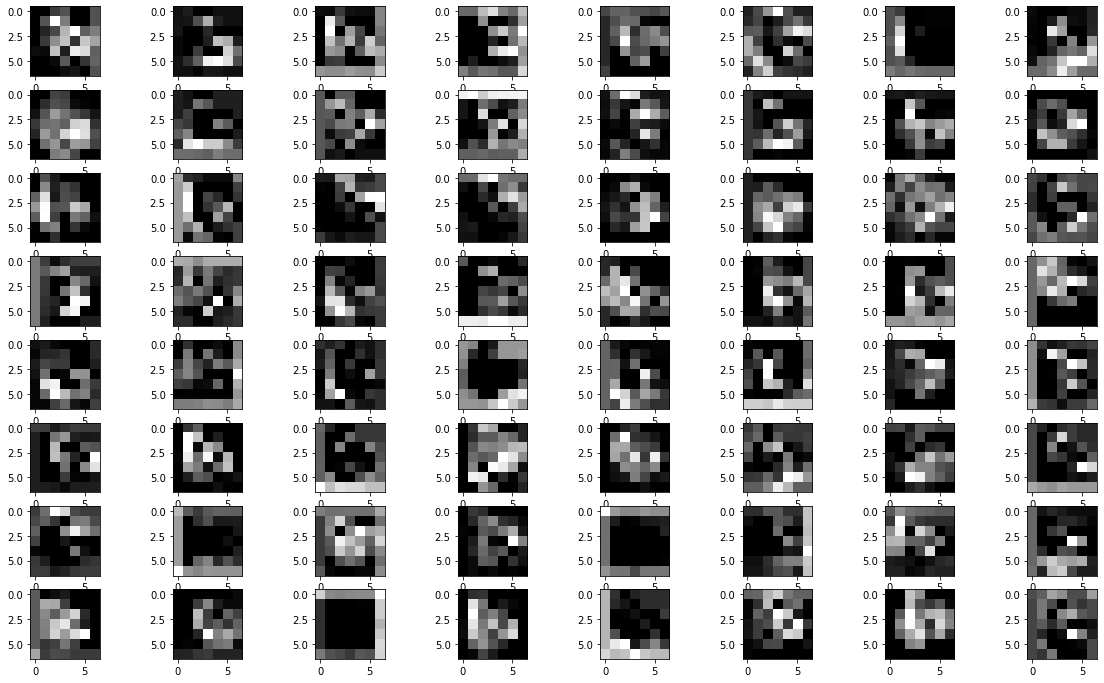

In [53]:
display_activation(activations, 8, 8, 7)